In [1]:
%load_ext autoreload
%autoreload 2
%cd ../

import numpy as np
from numpy import random
from numpy import linalg

import pandas as pd

import sklearn.datasets
import scipy

import torch

import matplotlib.pyplot as plt
from matplotlib.transforms import Bbox
%matplotlib inline

import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from utils.pickle import load_obj, save_obj, make_file_directory

/mlodata1/praneeth/signSGD-quentin/src


In [2]:
base_folder = 'results/main_experiments/'

In [3]:
save_folder = '../figs/main_experiments/'

In [4]:
def load(folders_list):
    res = []
    paths_list = ['train_losses', 'train_accuracies', 'test_losses', 'test_accuracies']
    for path in paths_list:
        res.append([])
        for folder in folders_list:
            l1 = load_obj(folder + '/1/' + path)
            l2 = load_obj(folder + '/2/' + path)
            l3 = load_obj(folder + '/3/' + path)
            res[-1].append(np.column_stack((l1, l2, l3)).T)
    return res

In [5]:
def errorfill(x, y, yerr, label=None, color=None, alpha_fill=0.3, ax=None):
    x, y = np.array(x), np.array(y)
    ax = ax if ax is not None else plt.gca()
    if np.isscalar(yerr) or len(yerr) == len(y):
        ymin = y - yerr
        ymax = y + yerr
    elif len(yerr) == 2:
        ymin, ymax = yerr
    base_line, = ax.plot(x, y, color=color)
    if color is None:
        color = base_line.get_color()
    ax.fill_between(x, ymax, ymin, label=label, color=color, alpha=alpha_fill)

In [6]:
def full_extent(ax, pad=0.0):
    """Get the full extent of an axes, including axes labels, tick labels, and
    titles."""
    # For text objects, we need to draw the figure first, otherwise the extents
    # are undefined.
    ax.figure.canvas.draw()
    items = ax.get_xticklabels() + ax.get_yticklabels() 
#    items += [ax, ax.title, ax.xaxis.label, ax.yaxis.label]
    items += [ax, ax.title]
    bbox = Bbox.union([item.get_window_extent() for item in items])

    return bbox.expanded(1.0 + pad, 1.0 + pad)

In [7]:
def plot_and_save(batch_size=8, name='resnet-cifar100'):
    optimizers = ['sgdm', 'signum','ssgdf', 'sssgd']
    folders_list = [base_folder + 'batchsize-' + str(batch_size) + '/' + name + '-' + optimizer for optimizer in optimizers]
    results_list = load(folders_list)
    x_labels = ['Epoch', 'Epoch', 'Epoch', 'Epoch']
    y_labels = ['Loss', 'Accuracy', 'Loss', 'Accuracy']
    titles = ['Train losses', 'Train accuracies', 'Test losses', 'Test accuracies']
    labels=['SGDm', 'Signum', 'SSGDf', 'sSSGD']
    start_epoch = 0
    end_epoch = 200
    
    
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

    x_range = np.arange(start_epoch, end_epoch)
    
    for index in range(4):
        for i, l in enumerate(results_list[index]):
            mean = np.mean(l, axis=0)
            std = np.std(l, axis=0)
            errorfill(x_range, mean[start_epoch:], std[start_epoch:], label=labels[i], ax=ax[index//2, index%2])
        ax[index//2, index%2].set_title(titles[index])
        ax[index//2, index%2].set_xlabel(x_labels[index])
        ax[index//2, index%2].set_ylabel(y_labels[index])
        ax[index//2, index%2].legend()
        
        extent = full_extent(ax[index//2, index%2]).transformed(fig.dpi_scale_trans.inverted())
        filename = save_folder + 'batchsize-' + str(batch_size) + '/' + name + '/' + titles[index]
        make_file_directory(filename)
        fig.savefig(filename, bbox_inches=extent)

In [8]:
def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

In [9]:
def save_plot(batch_size=8, name='resnet-cifar100', x_labels=['']*4, y_labels=['']*4, titles=['']*4, labels=None,
              names=['train_losses', 'train_accuracies', 'test_losses', 'test_accuracies'],
              y_lims=None):
    optimizers = ['sgdm', 'sssgd', 'signum', 'ssgdf']
    folders_list = [base_folder + 'batchsize-' + str(batch_size) + '/' + name + '-' + optimizer for optimizer in optimizers]
    results_list = load(folders_list)
    start_epoch = 0
    end_epoch = 200

    x_range = np.arange(start_epoch, end_epoch)
    
    for index in range(4):
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3.75, 2.5))
        plot_legend = labels is not None and index <= 1
        for i, l in enumerate(results_list[index]):
            mean = np.mean(l, axis=0)
            std = np.std(l, axis=0)
            if plot_legend:
                label = labels[i]
            else:
                label = None
            errorfill(x_range, mean[start_epoch:], std[start_epoch:], label=label, ax=ax)
        if y_lims is not None:
            ax.set_ylim([y_lims[index][0], y_lims[index][1]])
        ax.set_title(titles[index])
        ax.set_xlabel(x_labels[index], fontsize=12.5)
        ax.set_ylabel(y_labels[index], fontsize=12.5)
        if plot_legend:
            ax.legend(prop={'size': 11, 'variant': 'small-caps'})
        set_size(3.75, 2.5, ax)
        plt.subplots_adjust(bottom=0.15)
        
        filename = save_folder + 'batchsize-' + str(batch_size) + '/' + name + '/' + names[index]
        make_file_directory(filename)
        fig.savefig(filename + '.pdf')

In [10]:
x_labels = ['Epoch', 'Epoch', 'Epoch', 'Epoch']
y_labels = ['Loss', 'Accuracy', 'Loss', 'Accuracy']
titles = ['Train losses', 'Train accuracies', 'Test losses', 'Test accuracies']
labels = ['SGDm', 'signSGD', 'signSGDm', 'EF-signSGD']

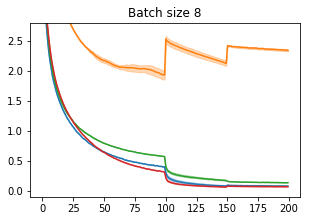

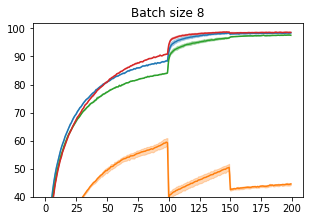

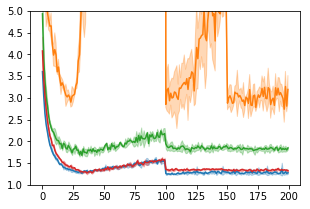

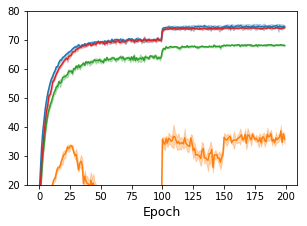

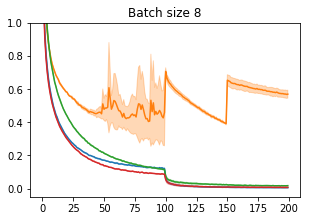

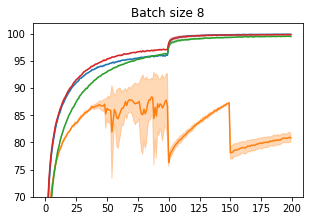

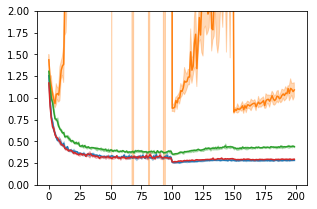

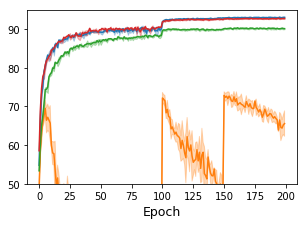

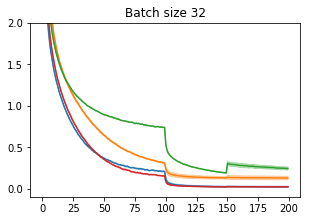

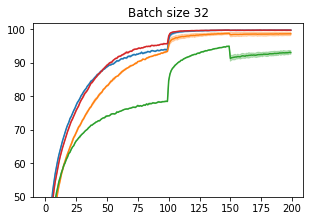

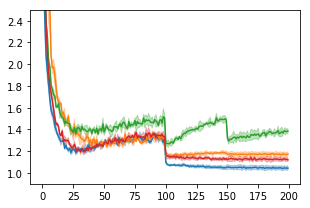

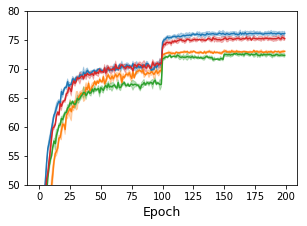

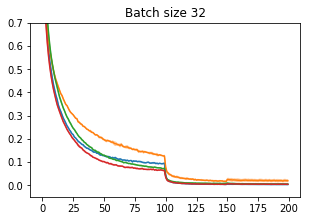

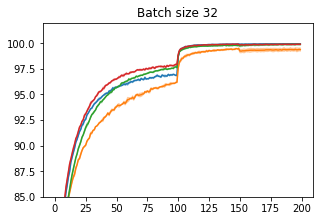

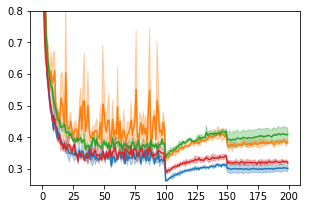

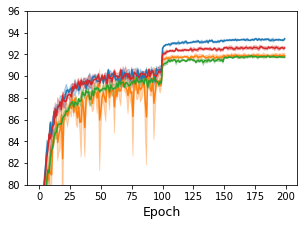

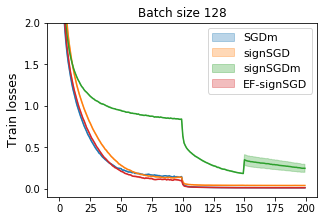

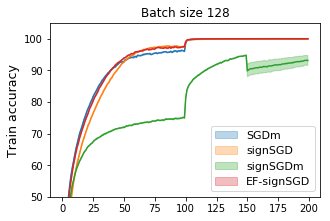

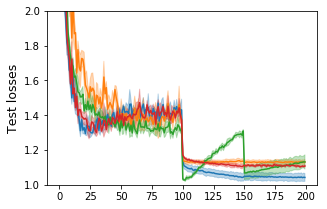

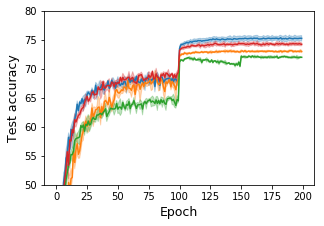

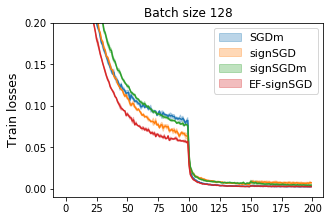

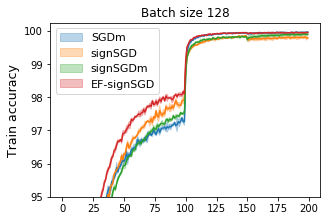

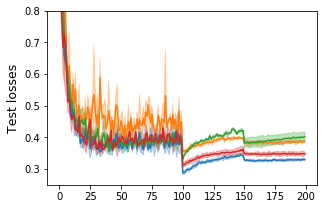

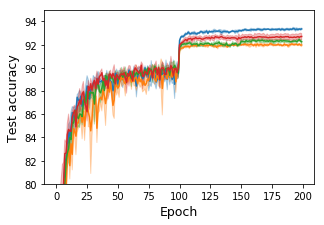

In [14]:
# Batchsize 8
save_plot(batch_size=8, name='resnet-cifar100', y_lims=[(-0.1, 2.8), (40, 102), (1, 5), (20, 80)],
          x_labels=['', '', '', 'Epoch'],
          titles=['Batch size 8', 'Batch size 8', '', ''])
save_plot(batch_size=8, name='vgg-cifar10', y_lims=[(-0.05, 1), (70, 102), (0, 2), (50, 95)],
          x_labels=['', '', '', 'Epoch'],
          titles=['Batch size 8', 'Batch size 8', '', ''])


# Batchsize 32
save_plot(batch_size=32, name='resnet-cifar100', y_lims=[(-0.1, 2), (50, 102), (0.9, 2.5), (50, 80)],
          x_labels=['', '', '', 'Epoch'], y_labels=['', '', '', ''],
          titles=['Batch size 32', 'Batch size 32', '', ''])
save_plot(batch_size=32, name='vgg-cifar10', y_lims=[(-0.05, 0.7), (85, 102), (0.25, 0.8), (80, 96)],
          x_labels=['', '', '', 'Epoch'], y_labels=['', '', '', ''], 
          titles=['Batch size 32', 'Batch size 32', '', ''])


# Batchsize 128
save_plot(batch_size=128, name='resnet-cifar100', y_lims=[(-0.1, 2), (50, 105), (1, 2), (50, 80)],
          labels=labels,
          x_labels=['', '', '', 'Epoch'], y_labels=['Train losses', 'Train accuracy', 'Test losses', 'Test accuracy'],
          titles=['Batch size 128', 'Batch size 128', '', ''])
save_plot(batch_size=128, name='vgg-cifar10', y_lims=[(-0.01, 0.2), (95, 100.25), (0.25, 0.8), (80, 95)],
          labels=labels,
          x_labels=['', '', '', 'Epoch'], y_labels=['Train losses', 'Train accuracy', 'Test losses', 'Test accuracy'],
          titles=['Batch size 128', 'Batch size 128', '', ''])

In [12]:
# max of means
def max_table(batch_size=8, name='resnet-cifar100'):
    optimizers = ['sgdm', 'signum','ssgdf', 'sssgd']
    folders_list = [base_folder + 'batchsize-' + str(batch_size) + '/' + name + '-' + optimizer for optimizer in optimizers]
    results_list = load(folders_list)

    index = 3
    vals = [0, 0, 0, 0]
    for i, l in enumerate(results_list[index]):
        vals[i] = np.max(np.mean(l, axis=0))
    for i, v in enumerate(vals):
        if v != max(vals):
            v -= max(vals)
        print('Batchsize ({0}) Opt ({1}) Maxacc ({2})'.format(batch_size, optimizers[i], np.round(v, 2)))
    print()

In [13]:
max_table(batch_size=8)
max_table(batch_size=32)
max_table(batch_size=128)

Batchsize (8) Opt (sgdm) Maxacc (74.91)
Batchsize (8) Opt (signum) Maxacc (-6.6)
Batchsize (8) Opt (ssgdf) Maxacc (-0.64)
Batchsize (8) Opt (sssgd) Maxacc (-36.35)

Batchsize (32) Opt (sgdm) Maxacc (76.22)
Batchsize (32) Opt (signum) Maxacc (-3.57)
Batchsize (32) Opt (ssgdf) Maxacc (-0.79)
Batchsize (32) Opt (sssgd) Maxacc (-3.04)

Batchsize (128) Opt (sgdm) Maxacc (75.35)
Batchsize (128) Opt (signum) Maxacc (-3.15)
Batchsize (128) Opt (ssgdf) Maxacc (-0.92)
Batchsize (128) Opt (sssgd) Maxacc (-2.21)



\begin{table}[]
\begin{tabular}{cc|c|c|c|c|}
\cline{3-6}
\multicolumn{1}{l}{}                                                                        &     & \multicolumn{4}{c|}{Algorithm} \\ \cline{3-6} 
\multicolumn{1}{l}{}                                                                        &     & SGDm  & Signum & SSGDf & sSSGD \\ \hline
\multicolumn{1}{|c|}{\multirow{3}{*}{\begin{tabular}[c]{@{}c@{}}Batch\\ size\end{tabular}}}
& 128 & 75.35 & -3.15 & -0.92 & -2.21 \\ \cline{2-6}
\multicolumn{1}{|c|}{}
& 32  & 76.22 & -3.57 & -0.79 & -3.04 \\ \cline{2-6} 
\multicolumn{1}{|c|}{}
& 8   & 74.91 & -6.6 & -0.64 & -36.35 \\ \hline
\end{tabular}
\caption[short]{Best mean test accuracy over the 3 repetitions for each batch size and each algorithm on the Resnet architecture}
\end{table}

In [14]:
max_table(batch_size=8, name='vgg-cifar10')
max_table(batch_size=32, name='vgg-cifar10')
max_table(batch_size=128, name='vgg-cifar10')

Batchsize (8) Opt (sgdm) Maxacc (93.09)
Batchsize (8) Opt (signum) Maxacc (-2.75)
Batchsize (8) Opt (ssgdf) Maxacc (-0.27)
Batchsize (8) Opt (sssgd) Maxacc (-20.22)

Batchsize (32) Opt (sgdm) Maxacc (93.42)
Batchsize (32) Opt (signum) Maxacc (-1.54)
Batchsize (32) Opt (ssgdf) Maxacc (-0.71)
Batchsize (32) Opt (sssgd) Maxacc (-1.49)

Batchsize (128) Opt (sgdm) Maxacc (93.38)
Batchsize (128) Opt (signum) Maxacc (-0.94)
Batchsize (128) Opt (ssgdf) Maxacc (-0.68)
Batchsize (128) Opt (sssgd) Maxacc (-1.31)



\begin{table}[]
\begin{tabular}{cc|c|c|c|c|}
\cline{3-6}
\multicolumn{1}{l}{}                                                                        &     & \multicolumn{4}{c|}{Algorithm} \\ \cline{3-6} 
\multicolumn{1}{l}{}                                                                        &     & SGDm  & Signum & SSGDf & sSSGD \\ \hline
\multicolumn{1}{|c|}{\multirow{3}{*}{\begin{tabular}[c]{@{}c@{}}Batch\\ size\end{tabular}}}
& 128 & 93.38 & -0.94 & -0.68 & -1.31 \\ \cline{2-6}
\multicolumn{1}{|c|}{}
& 32  & 93.42 & -1.54 & -0.71 & -1.49 \\ \cline{2-6} 
\multicolumn{1}{|c|}{}
& 8   & 93.09 & -2.75 & -0.27 & -20.22 \\ \hline
\end{tabular}
\caption[short]{Best mean test accuracy over the 3 repetitions for each batch size and each algorithm on the VGG architecture}
\end{table}

In [15]:
# mean of max
def max_table(batch_size=8, name='resnet-cifar100'):
    optimizers = ['sgdm', 'signum','ssgdf', 'sssgd']
    folders_list = [base_folder + 'batchsize-' + str(batch_size) + '/' + name + '-' + optimizer for optimizer in optimizers]
    results_list = load(folders_list)

    index = 3
    for i, l in enumerate(results_list[index]):
        max_ = np.mean(np.max(l, axis=1))
        print('Batchsize ({0}) Opt ({1}) Maxacc ({2})'.format(batch_size, optimizers[i], np.round(max_, 3)))

In [16]:
max_table(batch_size=8)
max_table(batch_size=32)
max_table(batch_size=128)

Batchsize (8) Opt (sgdm) Maxacc (75.03)
Batchsize (8) Opt (signum) Maxacc (68.667)
Batchsize (8) Opt (ssgdf) Maxacc (74.447)
Batchsize (8) Opt (sssgd) Maxacc (39.727)
Batchsize (32) Opt (sgdm) Maxacc (76.37)
Batchsize (32) Opt (signum) Maxacc (72.8)
Batchsize (32) Opt (ssgdf) Maxacc (75.563)
Batchsize (32) Opt (sssgd) Maxacc (73.233)
Batchsize (128) Opt (sgdm) Maxacc (75.427)
Batchsize (128) Opt (signum) Maxacc (72.35)
Batchsize (128) Opt (ssgdf) Maxacc (74.56)
Batchsize (128) Opt (sssgd) Maxacc (73.213)


In [10]:
from models import VGG, ResNet18

In [11]:
vgg_net = VGG('VGG19', num_classes=2)
vgg_param_dims = []
for name, param in vgg_net.named_parameters():
    vgg_param_dims.append(param.nelement())
vgg_param_dims = np.array(vgg_param_dims, dtype=float)

res_net = ResNet18(100)
resnet_param_dims = []
for name, param in res_net.named_parameters():
    resnet_param_dims.append(param.nelement())
resnet_param_dims = np.array(resnet_param_dims, dtype=float)

In [24]:
ratios_vgg_grad = load_obj('results/norm_ratio_experiments/batchsize-128/7vgg-cifar10-ssgdf/gradient_norm_ratios')
ratios_vgg_g = load_obj('results/norm_ratio_experiments/batchsize-128/7vgg-cifar10-ssgdf/g_norm_ratios')

ratios_resnet_grad = load_obj('results/norm_ratio_experiments/batchsize-32/3resnet-cifar100-ssgdf/gradient_norm_ratios')
ratios_resnet_g = load_obj('results/norm_ratio_experiments/batchsize-32/3resnet-cifar100-ssgdf/g_norm_ratios')

In [25]:
def normalize_results(res):
    res = np.array(res)
    for i in range(res.shape[0]):
        for j in range(res.shape[1]):
            res[i, j] = float(res[i, j])
    res = np.array(res, dtype=float)
    return res

In [26]:
ratios_vgg_grad = normalize_results(ratios_vgg_grad)
ratios_vgg_g = normalize_results(ratios_vgg_g)
ratios_resnet_grad = normalize_results(ratios_resnet_grad)
ratios_resnet_g = normalize_results(ratios_resnet_g)

0.133980765939


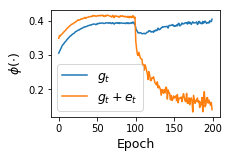

In [43]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3.3, 2.3))
ax.plot(ratios_vgg_grad[:,-1], label='$g_t$')
ax.plot(ratios_vgg_g[:,-1], label='$g_t + e_t$')
ax.set_title('')
ax.set_xlabel('Epoch', fontsize=12.5)
ax.set_ylabel('$\phi(\cdot)$', fontsize=12.5)
ax.legend(prop={'size': 12.5}, loc='lower left')
print(np.min(ratios_vgg_g[:,-1]))
plt.tight_layout()
fig.savefig('../figs/vgg_gradients_corrected_norms_ratios_comparison.pdf')

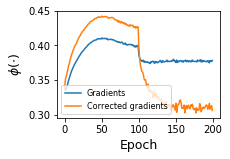

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3.3, 2.3))
ax.plot(np.average(ratios_resnet_grad, weights=resnet_param_dims, axis=1), label='Gradients')
ax.plot(np.average(ratios_resnet_g, weights=resnet_param_dims, axis=1), label='Corrected gradients')
ax.set_title('')
ax.set_xlabel('Epoch', fontsize=12.5)
ax.set_ylabel('$\phi(\cdot)$', fontsize=12.5)
ax.legend(prop={'size': 8}, loc='lower left')
plt.tight_layout()
fig.savefig('../figs/resnet_gradients_norms_ratios_comparison.pdf')

## Appendix lr tuning

In [101]:
from tune_lr import get_tuned_learning_rate

In [110]:
def Round_To_n(x, n):
    return round(x, -int(np.floor(np.sign(x) * np.log10(abs(x)))) + n)

In [114]:
lr_space = np.logspace(-5, 1, 9)
print(lr_space)
for i, x in enumerate(lr_space):
    lr_space[i] = Round_To_n(x, 1)
print(lr_space)

[1.00000000e-05 5.62341325e-05 3.16227766e-04 1.77827941e-03
 1.00000000e-02 5.62341325e-02 3.16227766e-01 1.77827941e+00
 1.00000000e+01]
[1.0e-05 5.6e-05 3.2e-04 1.8e-03 1.0e-02 5.6e-02 3.2e-01 1.8e+00 1.0e+01]


In [117]:
print(get_tuned_learning_rate('vgg', 'cifar10', 'sgdm'))
print(get_tuned_learning_rate('vgg', 'cifar10', 'ssgdf'))
print(get_tuned_learning_rate('vgg', 'cifar10', 'signum'))
print(get_tuned_learning_rate('vgg', 'cifar10', 'sssgd'))

print(get_tuned_learning_rate('resnet', 'cifar100', 'sgdm'))
print(get_tuned_learning_rate('resnet', 'cifar100', 'ssgdf'))
print(get_tuned_learning_rate('resnet', 'cifar100', 'signum'))
print(get_tuned_learning_rate('resnet', 'cifar100', 'sssgd'))

0.01
0.05623413251903491
5.623413251903491e-05
0.05623413251903491
0.01
0.05623413251903491
0.00031622776601683794
0.05623413251903491


Deep net architectures

VGG (Cifar 10)

We used a standard VGG 19 architecture consisting in the following layers :
64 -> 64 -> M -> 128 -> 128 -> M -> 256 -> 256 -> 256 -> 256 -> M -> 512 -> 512 -> 512 -> 512 -> M -> 512 -> 512 -> 512 -> 512 -> M
where M denotes max pool layers (kernel 2 and stride 2), and a number $n$ represents a two dimensional convolution layer with $n$ channels a kernel of 3 and a padding of 1. All of them are followed by a batch normalization layer and the activation is ReLU. 

Resnet (Cifar 100)

We used a standard Resnet 18 architecture 

Learning rate tuning

For all the experiments, only the initial learning rate was tuned. It was then divided by 10 at epochs 100 and 150. We also chose the tuned the learning rate only under the batch size 128 experiments, and it was naturally divided respectively by 4 and by 16 for the 32 and 8 batch size experiments. The initial learning rates for each experiment and each algorithm were tuned by picking the one giving the maximal test accuracy after 100 epochs in all of these configurations. The set of possible learning rates was a logarithmic space of 9 values, ranging from $10^-5$ to $10$.

The numbers below are rounded values (1 significant digit) of the actual learning rates.

Experiment 1 : VGG architecture

SGD with momentum :
1.0 \cdot 10^-05, 5.6 \cdot 10^-05, 3.2 \cdot 10^-04, 1.8 \cdot 10^-03, \textbf{1.0 \cdot 10^-02}, 5.6 \cdot 10^-02, 3.2 \cdot 10^-01, 1.8 \cdot 10^0, 1.0 \cdot 10^1

\esignsgd :
1.0 \cdot 10^-05, 5.6 \cdot 10^-05, 3.2 \cdot 10^-04, 1.8 \cdot 10^-03, 1.0 \cdot 10^-02, \textbf{5.6 \cdot 10^-02}, 3.2 \cdot 10^-01, 1.8 \cdot 10^0, 1.0 \cdot 10^1

\signum :
1.0 \cdot 10^-05, \textbf{5.6 \cdot 10^-05}, 3.2 \cdot 10^-04, 1.8 \cdot 10^-03, 1.0 \cdot 10^-02, 5.6 \cdot 10^-02, 3.2 \cdot 10^-01, 1.8 \cdot 10^0, 1.0 \cdot 10^1

Scaled {\signsgd} :
1.0 \cdot 10^-05, 5.6 \cdot 10^-05, 3.2 \cdot 10^-04, 1.8 \cdot 10^-03, 1.0 \cdot 10^-02, \textbf{5.6 \cdot 10^-02}, 3.2 \cdot 10^-01, 1.8 \cdot 10^0, 1.0 \cdot 10^1

Experiment 2 : Resnet architecture

SGD with momentum :
1.0 \cdot 10^-05, 5.6 \cdot 10^-05, 3.2 \cdot 10^-04, 1.8 \cdot 10^-03, \textbf{1.0 \cdot 10^-02}, 5.6 \cdot 10^-02, 3.2 \cdot 10^-01, 1.8 \cdot 10^0, 1.0 \cdot 10^1

\esignsgd :
1.0 \cdot 10^-05, 5.6 \cdot 10^-05, 3.2 \cdot 10^-04, 1.8 \cdot 10^-03, 1.0 \cdot 10^-02, \textbf{5.6 \cdot 10^-02}, 3.2 \cdot 10^-01, 1.8 \cdot 10^0, 1.0 \cdot 10^1

\signum :
1.0 \cdot 10^-05, 5.6 \cdot 10^-05, \textbf{3.2 \cdot 10^-04}, 1.8 \cdot 10^-03, 1.0 \cdot 10^-02, 5.6 \cdot 10^-02, 3.2 \cdot 10^-01, 1.8 \cdot 10^0, 1.0 \cdot 10^1

Scaled {\signsgd} :
1.0 \cdot 10^-05, 5.6 \cdot 10^-05, 3.2 \cdot 10^-04, 1.8 \cdot 10^-03, 1.0 \cdot 10^-02, \textbf{5.6 \cdot 10^-02}, 3.2 \cdot 10^-01, 1.8 \cdot 10^0, 1.0 \cdot 10^1